# Biodiversity Intactness Index change in Phoenix, AZ

**Author:** Marina Kochuten

**Repository:** https://github.com/marinakochuten/phoenix-bii-change

## About

In 2021, Maricopa County —home to the Phoenix metropolitan area— was identified as the U.S. county with the most significant increase in developed land since 2001 [1]. This rapid urban sprawl has profound implications for biodiversity and the health of surrounding natural ecosystems.

In this notebook, I investigate the impacts of urban expansion by analyzing a dataset that captures values for the Biodiversity Intactness Index (BII) [2]. The Biodiversity Intactness Index (BII) measures biodiversity change using abundance data on plants, fungi and animals worldwide. The BII shows how local terrestrial biodiversity responds to human pressures such as land use change and intensification [3].

I examine changes in BII in the Phoenix county subdivision area between 2017 and 2020, shedding light on how urban growth affects biodiversity over time.


## Highlights

- Access data through an API
- Vector raster intersctions and raster algebra
- Visualizing spatial data using `matplotlib`

## Data

**Biodiversity Intactness Index (BII) Time Series:** I access the io-biodiversity collection from the Microsoft Planetary Computer STAC catalog using an API. In my analysis, I use the 2017 and 2020 rasters covering the Phoenix subdivision.

**Citation:** Microsoft Planetary Computer data catalogue (2024), io-biodiversity Collection [Data set] Available from: https://planetarycomputer.microsoft.com/dataset/io-biodiversity. Access date: December 3, 2024.

**Phoenix Subdivision Shapefile:** I use a shapefile containing county boundary lines from the U.S. Census Bureau

**Citation:** U.S. Census Bureau. (2022). “tl_2022_04_cousub”, TIGER/Line Shapefiles. https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2022&layergroup=County+Subdivisions.  Access date: December 3, 2024.

## References

[1] Z. Levitt and J. Eng, “Where America’s developed areas are growing: ‘Way off into the horizon’,” The Washington Post, Aug. 2021, Available: https://www.washingtonpost.com/nation/interactive/2021/land-development-urban-growth-maps/ [Accessed: Nov. 22, 2024]

[2] F. Gassert, J. Mazzarello, and S. Hyde, “Global 100m Projections of Biodiversity Intactness for the years 2017-2020 [Technical Whitepaper].” Aug. 2022. Available: https://ai4edatasetspublicassets.blob.core.windows.net/assets/pdfs/io -biodiversity/Biodiversity_Intactness_whitepaper.pdf

[3] Measurement of Biodiversity. (2024, 16 November). In Wikipedia. https://en.wikipedia.org/wiki/Measurement_of_biodiversity


## Import libraries

In [28]:
# Import libraries ----
# For general analysis
import numpy as np
import pandas as pd

# For spatial data
import geopandas as gpd
import rioxarray as rioxr
from shapely import box

# For STAC API
import pystac_client  # To access STAC catalogs
import planetary_computer  # To sign items from the MPC STAC catalog

# For plotting
import matplotlib.pyplot as plt
from IPython.display import Image  # To nicely display images
import contextily as cx   # For basemap
import matplotlib.patches as mpatches   # For creating custom legend

# Set Pandas to display all columns
pd.set_option("display.max.columns", None)

## Access Data: BII Time Series

For the BII time series, I access the `io-biodiversity` collection from the Microsoft Planetary Computer STAC catalog and use the 2017 and 2020 rasters covering the Phoenix subdivision (bounding box coordinates:[-112.826843, 32.974108, -111.184387, 33.863574])

In [29]:
# Create bounding box for search
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]
bbox

[-112.826843, 32.974108, -111.184387, 33.863574]

In [30]:
# Open MPC data catalog (establish connection to API)
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# Search MPC catalog
search = catalog.search(collections = ['io-biodiversity'],
                       bbox = bbox
                       )

# Retrive search items
items = search.item_collection()
print(f"Returned {len(items)} Items")
items

Returned 4 Items


There are 4 items in my search, one raster for each year in the range 2017 - 2020. 

## BII Time Series Exploration

First, I'll take a quick look at one of the pre-redered images from the catalog

In [31]:
# Select unique search items for 2020 and 2017
item2020 = items[0]
item2017 = items[3]

# Display a pre-rendered image
Image(url=item2020.assets['rendered_preview'].href, width=400)

Here, we have a raster showing biodiversity intactness. Darker green indicates higher intactness.

Let's dive a litter deeper by importing the rasters for 2017 and 2020. Down the line, I will compare changes between these two rasters to show BII changes from 2017 to 2020!

In [32]:
# Access raster data from items
bii_2020 = rioxr.open_rasterio(item2020.assets['data'].href)
bii_2017 = rioxr.open_rasterio(item2017.assets['data'].href)

# Let's look at the data for 2020
bii_2020

<xarray.DataArray (band: 1, y: 7992, x: 7992)> Size: 255MB
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

Notice that band is a dimension of length 1. We can go ahead and “squeeze” the raster to simplify it. I will do this for both my 2017 and my 2020 rasters:

In [33]:
# Remove length 1 dimension (band)
bii_2020 = bii_2020.squeeze().drop_vars('band')
bii_2017 = bii_2017.squeeze().drop_vars('band')

print("Sizes of dimensions, bii_2020:", dict(bii_2020.sizes))
print("Sizes of dimensions, bii_2017:", dict(bii_2017.sizes))

Sizes of dimensions, bii_2020: {'y': 7992, 'x': 7992}
Sizes of dimensions, bii_2017: {'y': 7992, 'x': 7992}


Lastly, I want to know the CRS of this data.

In [34]:
# Check raster CRS
bii_2020.rio.crs

CRS.from_epsg(4326)

The CRS of my rasters is EPSG:4326! I will keep this in mind as I explore my next geospatial object, the Phoenix Subdivision shapefile.

## Access Data: Phoenix Subdivision Shapefile

In [35]:
# Read in the shapefile
arizona = gpd.read_file('data/tl_2022_04_cousub.shp')

## Phoenix Subdivision Shapefile exploration

In [36]:
# Look at the head of the data
arizona.head(3)

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CNECTAFP,NECTAFP,NCTADVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,04,005,91198,01934931,0400591198,Flagstaff,Flagstaff CCD,22,Z5,G4040,None,None,None,S,12231052883,44653332,+35.1066114,-111.3662497,"POLYGON ((-112.13370 35.85596, -112.13368 35.8..."
1,04,005,91838,01934953,0400591838,Kaibab Plateau,Kaibab Plateau CCD,22,Z5,G4040,None,None,None,S,7228864534,29327221,+36.5991097,-112.1368033,"POLYGON ((-112.66039 36.53941, -112.66033 36.5..."
2,04,005,91683,01934950,0400591683,Hualapai,Hualapai CCD,22,Z5,G4040,None,None,None,S,2342313339,3772690,+35.9271665,-113.1170408,"POLYGON ((-113.35416 36.04097, -113.35416 36.0..."


<Axes: >

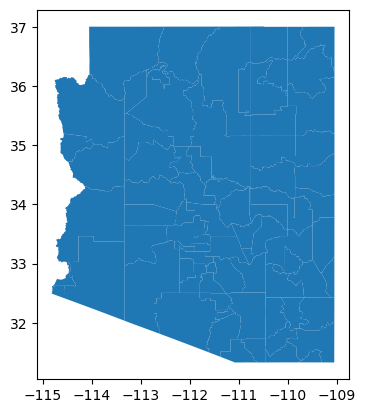

In [37]:
# Preliminary plot
arizona.plot()

The shapefile contains data for all of Arizona. Let's do a bit of processing to clean the column names and subset to Phoenix.

<Axes: >

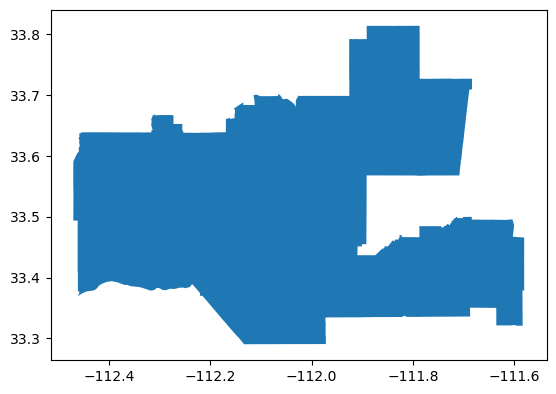

In [38]:
# Convert column names to lowercase
arizona.columns = arizona.columns.str.lower()

# Filter to Phoenix
phoenix = arizona[arizona.name == "Phoenix"]

# Preliminary plot
phoenix.plot()

In [39]:
# Check the CRS
phoenix.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

The CRS of this `GeoDataFrame` is EPSG:4269. Note that this is different from the BII rasters, and I will need to match them before they can interact. 

In [40]:
# Match shapefile CRS to raster CRS
phoenix = phoenix.to_crs(bii_2020.rio.crs)
assert phoenix.crs == bii_2020.rio.crs

## Map the Phoenix subdivision

To contextualize the Phoenix subdivision within its broader geographic context, I will include a basemap from the `contextily` package. The simplest way to access `contextily` and get a background map to go with your geographic data is to use the `add_basemap` method. Because the method takes a `matplotlib` axis, it is easy to integrate contextily with any other package for geospatial data that plots to matplotlib, such as `rasterio` and `geopandas`.

Setting the parameter `source` within the `add_basemap` method, I can choose the style of basemap. In this case, I am going to use CartoDB.Positron for its simplicity. 

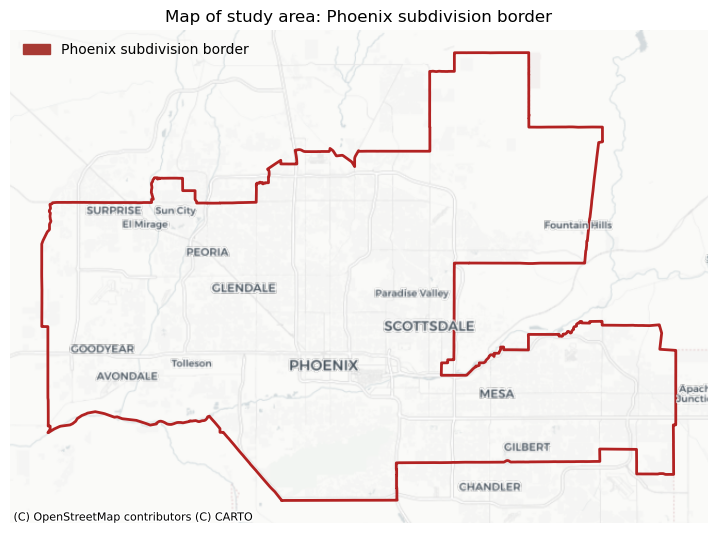

In [41]:
# Initialize plot
fig, ax = plt.subplots(figsize = (9, 9))

# Remove axes for cleaner map
ax.axis('off')

# Add Phoenix subdivision
phoenix.plot(ax = ax, color = "none", edgecolor = "firebrick", linewidth = 2)

# Add basemap
cx.add_basemap(ax, crs = phoenix.crs, source = cx.providers.CartoDB.PositronNoLabels)
cx.add_basemap(ax, crs = phoenix.crs, source = cx.providers.CartoDB.PositronOnlyLabels)   # To bring labels above boundary outline

# Create legend for Phoenix border
legend_border = mpatches.Patch(color = "#A83A34", 
                               label = 'Phoenix subdivision border')

# Plot legend
ax.legend(handles = [legend_border], 
          loc = 'upper left', 
          fontsize = 10, 
          facecolor = 'none', 
          edgecolor = 'none')

# Plot title
ax.set_title('Map of study area: Phoenix subdivision border')

plt.show()


## Calculate biodiversity intactness in the Phoenix subdivision

Next, I am interested in calculating the percentage of area of the Phoenix subdivision with a BII of at least 0.75 in both 2017 and 2020. I will use these to then find areas that lost BII over those 4 years. 

First, taking a look at how the raster is located with respect to the Phoenix subdivision:


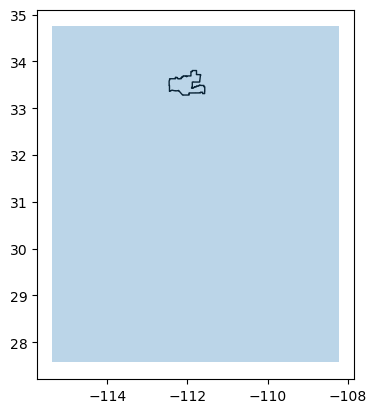

In [42]:
# Create GeoDataFrame from raster bounding box
bii_bbox = gpd.GeoDataFrame(geometry = [box(*bii_2020.rio.bounds())],
                             crs = bii_2020.rio.crs)

# Plot raster boundary and Phoenix boundary
fig, ax = plt.subplots()
phoenix.plot(ax=ax, color='white', edgecolor ='black')
bii_bbox.plot(ax=ax, alpha=0.3)  

plt.show()

I see that I need to crop the BII rasters to the extent of the Phoenix subdivision. Clipping can be a costly operation for such a big raster relative to a detailed geometry. So we will perform the clipping in two steps:

1. Clip the raster using the Phoenix subdivision bounding box using `rio.clip_box()` and then
2. Clip the simplified raster to the Phoenix subdivision using `rio.clip()`.

In [43]:
# Clip large raster to detailed geometry in two steps
bii_2020_step1 = bii_2020.rio.clip_box(*phoenix.total_bounds)
bii_2020_clip = bii_2020_step1.rio.clip(phoenix.geometry)

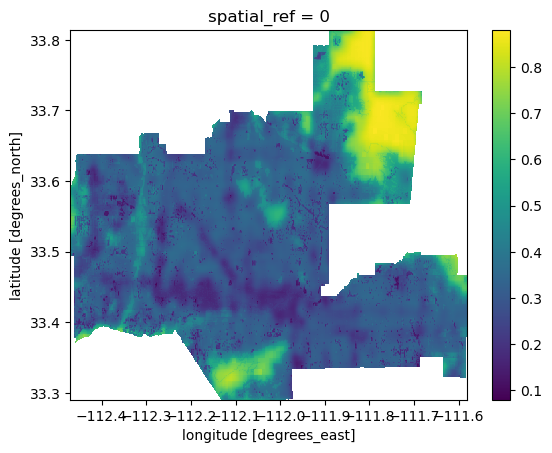

In [44]:
# Take a look at the clipped raster
bii_2020_clip.plot()

Now, the BII raster for 2020 is clipped to the Phoenix subdivision! I will repeat the process for the 2017 raster, and then move on to the next step.

In [45]:
# Clip large raster to detailed geometry in two steps
bii_2017_step1 = bii_2017.rio.clip_box(*phoenix.total_bounds)
bii_2017_clip = bii_2017_step1.rio.clip(phoenix.geometry)

Next, I want to select areas in each raster that have a BII of at least 0.75.

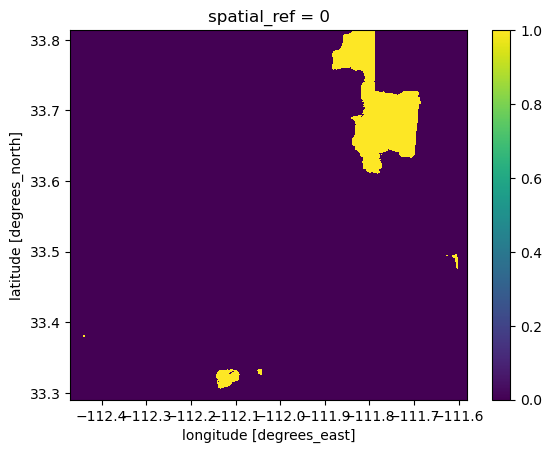

In [46]:
# Create a new object where if BII >= 0.75, the new value = True, and if BII < 0.75, the new value = False
bii_2017_intact = bii_2017_clip >= 0.75
bii_2017_intact.plot()

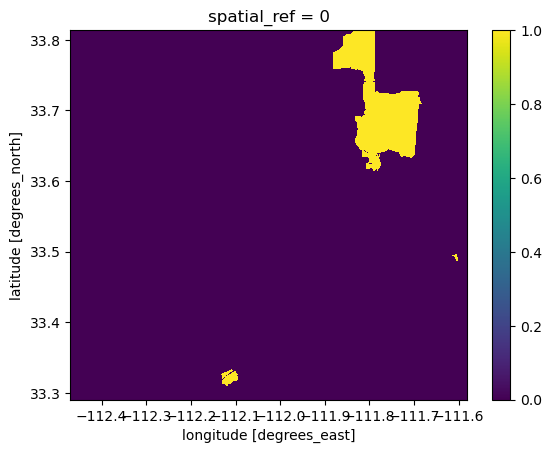

In [47]:
# Repeat for 2020
bii_2020_intact = bii_2020_clip >= 0.75
bii_2020_intact.plot()

Lastly, I can calculate the percentage of area in the Phoenix subdivision that has a BII of at least 0.75. To do so, I will calculate the total area in the subdivision and then divide the area where BII >= 0.75 by the total subdivision area. For ease of calculation, I will be using number of cells in the rasters to represent area. 

First, I use `np.unique()` to get the number of pixels that were < 0.75 and >= 0.75 in the cropped rasters for 2017 and 2020. By setting the parameter `return_counts = True`, I can see both the unique values and their counts. 

In [48]:
# Find the total count of values that are < 0.75 and  >= 0.75 for 2017
values_2017, counts_2017 = np.unique(bii_2017_intact, return_counts=True)

# Create a data frame with the pixel counts for 2017
pix_counts_2017 = pd.DataFrame({"above_threshold" : values_2017,
                                "number_of_pix" : counts_2017})

# Find the total count of values that are < 0.75 and  >= 0.75 for 2020
values_2020, counts_2020 = np.unique(bii_2020_intact, return_counts=True)

# Create a data frame with the pixel counts for 2020
pix_counts_2020 = pd.DataFrame({"above_threshold" : values_2020,
                                "number_of_pix" : counts_2020})

# Look at the 2017 data frame
pix_counts_2017

,above_threshold,number_of_pix
0,False,553037
1,True,24133


In [49]:
# Look at the 2020 data frame
pix_counts_2020

,above_threshold,number_of_pix
0,False,555184
1,True,21986


Next, I want to calculate the total number of pixels within the Phoenix subdivision. I use the same process as above to find the total area of the Phoenix subdivision using the 2020 clipped BII raster.

In [50]:
# Find areas where values in the bii_2020_clip raster are above 0 , representing all the pixels within the Phoenix subdivision as True
total_area = bii_2020_clip > 0

# Find the count of pixels where the above returned true, representing the total number of pixels within Phoenix
values, counts = np.unique(total_area, return_counts=True)

# Place the counts and values in a data frame
total_area = pd.DataFrame({"above_zero" : values,
                           "number_pixels" : counts})

total_area

,above_zero,number_pixels
0,False,238476
1,True,338694


In [51]:
# Access the value contianing the number of pixels within the Phoenix subdivision and save into a variable
total_area = total_area.iloc[1,1]
total_area

338694

Now, I can divide the number of pixels that are above the 0.75 threshold by the total number of pixels for 2017 and 2020 to find the percentage of area in the Phoenix subdivision that has a BII of at least 0.75.

In [52]:
# Calculate the percentage of area in Phoenix that has a BII of >= 0.75 in 2017 and 2020
percent_intact_2017 = (pix_counts_2017.iloc[1, 1] / total_area) * 100
percent_intact_2020 = (pix_counts_2020.iloc[1, 1] / total_area) * 100

print("The percentage of area for 2017 is: ",  round(percent_intact_2017,2), "%")
print("The percentage of area for 2020 is: ",  round(percent_intact_2020, 2), "%")
print("The percentage of area lost from 2017 to 2020 is: ", round(percent_intact_2017 - percent_intact_2020, 2), "%")

The percentage of area for 2017 is:  7.13 %
The percentage of area for 2020 is:  6.49 %
The percentage of area lost from 2017 to 2020 is:  0.63 %


## Visualize the change in biodiversity intactness from 2017 to 2020

Now, I want to create a visualization showing the area with BII >= 0.75 in 2017 that was lost by 2020. I will need to create a raster that contains a value of 1 where BII was >= 0.75 in 2017 but not in 2020. 

In [53]:
# Change the values in my BII rasters from True/False to 1 and 0
bii_2017_int = bii_2017_intact.astype('int')
bii_2020_int = bii_2020_intact.astype('int')
np.unique(bii_2017_int)

array([0, 1])

When I subtract the 2020 BII raster from the 2017 BII raster, I then have a new raster with a value of 1 in areas that had BII >= 0.75 in 2017 but not in 2020.

In [54]:
# Create raster with BII change from 2017 to 2020
bii_change = bii_2017_int - bii_2020_int
np.unique(bii_change)

array([-1,  0,  1])

Notice that we have 3 unique values, -1, 0, and 1. To see only areas that lost BII, I want to select the cells where `bii_change == 1`

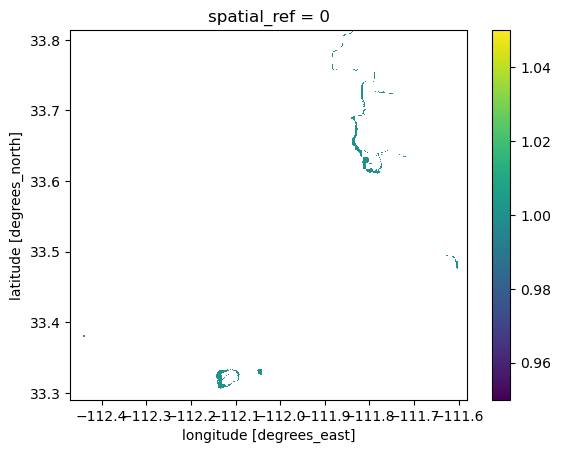

In [55]:
# Select cells where BII was lost from 2017 to 2020
bii_loss = bii_change.where(bii_change == 1)
bii_loss.plot()

Now, I am ready to piece things together:

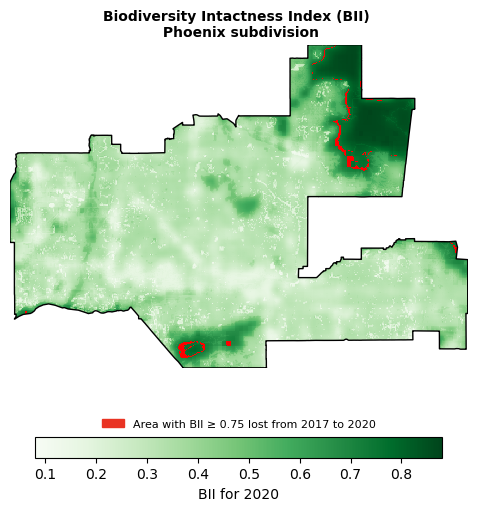

In [56]:
# Initialize figure
fig, ax = plt.subplots(figsize = (7, 6))

# Remove axes for cleaner plot
ax.axis('off')

# Add 2020 BII raster
bii_2020_clip.plot(ax = ax, 
                   cmap = 'Greens',
                   cbar_kwargs = {"location": "bottom",
                                  "label": "BII for 2020",
                                  "shrink" : 0.75})

# Add BII loss
bii_loss.plot(ax = ax,
              cmap = 'brg',
              add_colorbar = False)

# Create legend for BII loss
legend_loss = mpatches.Patch(color = "#E93323", label = 'Area with BIl ≥ 0.75 lost from 2017 to 2020')

# Plot legend
ax.legend(handles = [legend_loss], 
          loc = 'lower center',
          bbox_to_anchor=(0.5, -0.22), 
          fontsize = 8, 
          facecolor = 'none', 
          edgecolor = 'none')

# Add Phoenix boundary
phoenix.plot(ax = ax,
             color = "none",
             edgecolor = "black",
             linewidth = 1)

# Add plot title
ax.set_title("Biodiversity Intactness Index (BII) \n Phoenix subdivision", weight = 'bold', fontsize = '10')

plt.show()



This figure shows the Biodiversity Intactness Index (BII) change in the Phoenix subdivision from 2017 to 2020. In that time, 0.63% of the area with BII over 0.75 was lost, shown in red on the map. 